In [87]:
import os
import sys
import pandas as pd
import numpy as np

import shap 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    auc,
    roc_auc_score as auc_roc,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)


PROJECT_NAME = 'UFAL-DS'
curdir = os.path.abspath(os.path.curdir).split('/')
project_index = curdir.index(PROJECT_NAME)
os.chdir('/' + os.path.join(*curdir[:project_index + 1]))

In [2]:
aposentados = pd.read_csv("data/processed/aposentados.csv")
abono = pd.read_csv("data/processed/abono.csv")

aposentados = aposentados.drop_duplicates(subset=['name', 'cpf'], keep='first')
abono = abono.drop_duplicates(subset=['name', 'cpf'], keep='first')

aposentados["retirement_year"] = pd.to_datetime(aposentados.retirement_date).dt.year

use_cols = [
    'registration_n', 'agency_acronym', 'superior_agency_cod', 
    'classes', 'pattern', 'ref', 'level', 'retirement_type', 
    'legal_substantiation', 'doc_title', 'retirement_date',
    'admission_type', 'admission_date', 'value'
]
data = abono.merge(aposentados[['name', 'cpf'] + use_cols], left_on=['name', 'cpf'], right_on=['name', 'cpf'])

data.shape

(22213, 29)

In [3]:
data.loc[data.role.str.contains("medico"), "role_gp"] = "medico"
data.loc[data.role.str.contains("psicologo"), "role_gp"] = "medico"
data.loc[data.role.str.contains("odont"), "role_gp"] = "medico"
data.loc[data.role.str.contains("tecnico"), "role_gp"] = "tecnico"
data.loc[data.role.str.contains("tec"), "role_gp"] = "tecnico"
data.loc[data.role.str.contains("professor"), "role_gp"] = "professor"
data.loc[data.role.str.contains("agente"), "role_gp"] = "agente"
data.loc[data.role.str.contains("ag "), "role_gp"] = "agente"
data.loc[data.role.str.contains("aux"), "role_gp"] = "auxiliar"
data.loc[data.role.str.contains("analista"), "role_gp"] = "analista"
data.loc[data.role.str.contains("assistente"), "role_gp"] = "assistente"
data.loc[data.role.str.contains("operador"), "role_gp"] = "operador"
data.loc[data.role.str.contains("policia"), "role_gp"] = "policia"
data.loc[data.role.str.contains("engenhe"), "role_gp"] = "engenheiro"
data.loc[data.role.str.contains("especialista"), "role_gp"] = "especialista"
data.loc[data.role.str.contains("servente"), "role_gp"] = "servente"
data.loc[data.role.str.contains("auditor"), "role_gp"] = "auditor"
data.loc[data.role.str.contains("administrador"), "role_gp"] = "administrador"
data.loc[data.role.str.contains("motorista"), "role_gp"] = "motorista"
data.loc[data.role.str.contains("datilografo"), "role_gp"] = "datilografo" 

data.loc[data.role_gp.isna(), "role_gp"] = "outros" 

In [4]:
data["diff_state"] = data.apply(lambda row: 1 if row["upag_state"] == row["state"] else 0, axis=1)
data["year_admission"] = pd.to_datetime(data["admission_date"]).dt.year
data["month_admission"] = pd.to_datetime(data["admission_date"]).dt.month

In [10]:
desc = data['value_y'].describe()
desc

count     22213.000000
mean       6808.578038
std        5724.874371
min           0.620000
25%        3614.290000
50%        4936.100000
75%        7531.210000
max      106853.170000
Name: value_y, dtype: float64

In [23]:
outliers_upper = (desc["75%"] - desc["25%"]) * 1.5 + desc["75%"]
data[data.value_y > outliers_upper].shape[0] / data.shape[0]

0.1051636429118084

In [33]:
data["outlier"] = (
    data.value_y > outliers_upper
)

In [35]:
data.outlier.value_counts()

False    19877
True      2336
Name: outlier, dtype: int64

In [79]:
numeric_features = [
    "years", "months", "level", "superior_agency_cod", 
    "diff_state", "year_admission", "month_admission"
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

cat_features_ordinal = [
    "status", "role_gp", "admission_type", "gender",
    "educational_level", "classes",  "retirement_type"
]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features_ordinal)]
)

X = data[numeric_features + cat_features_ordinal]
y = data["outlier"]

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.939


In [88]:
def auc_pr(y_true, predicted_proba):
    precision, recall, _ = precision_recall_curve(y_true, predicted_proba)
    return auc(recall, precision)

In [89]:

y_pred = clf.predict_proba(X_test)
auc = auc_pr(y_test, y_pred[:, 1])
print("AUC PR", auc)
print("ROC AUC", auc_roc(y_test, y_pred[:, 1]))

AUC PR 0.7203102928294605
ROC AUC 0.9298386648209971


In [82]:
df_prediction = pd.DataFrame({'target':y_test, 'pred':y_pred[:, 1]})

positive = df_prediction.loc[df_prediction.target == True, 'pred']
negative = df_prediction.loc[df_prediction.target == False, 'pred']

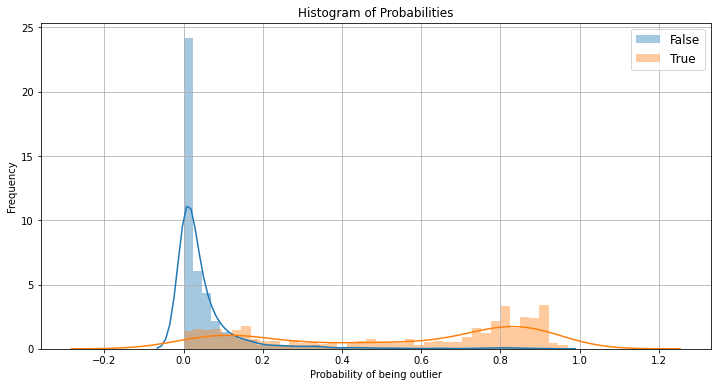

In [83]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])

f, ax = plt.subplots(1, 1, figsize=(12,6))
_ = sns.distplot(negative, bins=40, ax=ax, label='False')
_ = sns.distplot(positive, bins=40, ax=ax, label='True')
_ = ax.set_title('Histogram of {}'.format("Probabilities"))
_ = ax.set_ylabel('Frequency')
_ = ax.set_xlabel("Probability of being outlier")
_ = ax.legend(prop={'size': 12})
_ = ax.grid()

_ = plt.legend({'False':negative, 'True':positive}, fontsize='large')

In [72]:
x = clf.named_steps['preprocessor'].transform(X_test)

treeExplainer = shap.TreeExplainer(clf.steps[-1][1])
shap_values = treeExplainer.shap_values(x)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


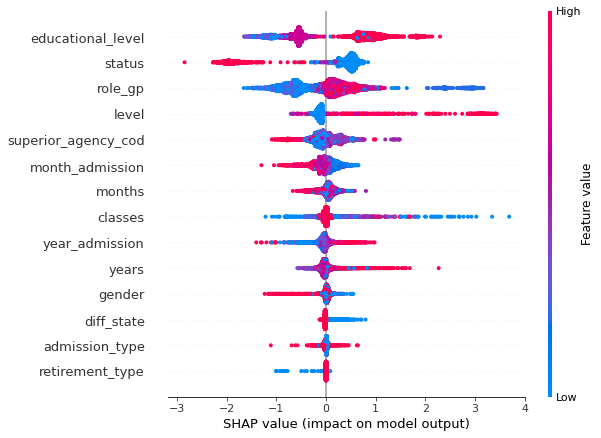

In [74]:
df = X_test.copy()
d = {i:col for i, col in enumerate(df.columns)}

for i in range(0, 14):
    df[d[i]] = x[:, i]
    
shap.summary_plot(shap_values[1], df)

PR AUC: 0.720
ROC AUC: 0.930


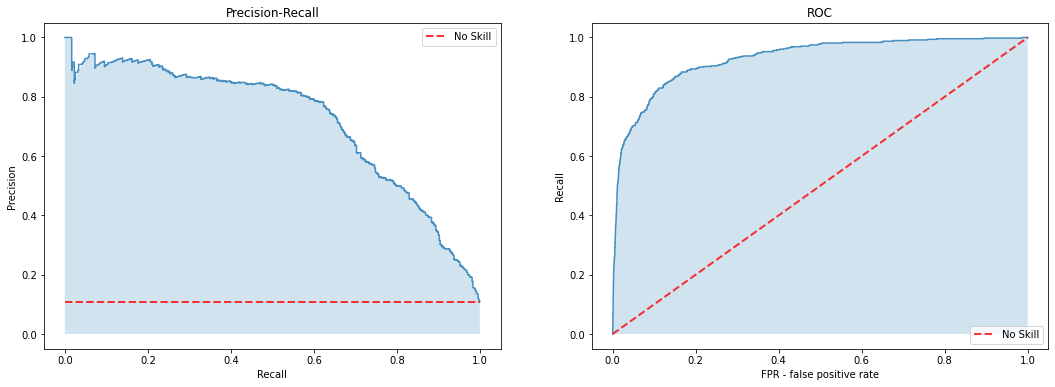

In [93]:
ground_truth, predictions = df_prediction.target, df_prediction.pred

f, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1, 1]}, figsize=(18, 6)
)

precision, recall, _ = precision_recall_curve(ground_truth, predictions)
print(f"PR AUC: {auc:.3f}")

ax1.step(recall, precision, alpha=0.8, where="post")
ax1.fill_between(recall, precision, alpha=0.2)

no_gain_theoretical = np.sum(ground_truth) / len(ground_truth)
ax1.plot(
    [no_gain_theoretical, no_gain_theoretical],
    linestyle="--",
    lw=2,
    color="r",
    alpha=0.8,
    label="No Skill",
)

ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title(f"Precision-Recall")
ax1.legend(loc="upper right")

fpr, recall, _ = roc_curve(ground_truth, predictions)
roc_auc_score_value = auc_roc(ground_truth, predictions)
print(f"ROC AUC: {roc_auc_score_value:.3f}")

ax2.step(fpr, recall, alpha=0.8, where="post")
ax2.fill_between(fpr, recall, alpha=0.2)

ax2.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8, label="No Skill")

ax2.set_xlabel("FPR - false positive rate")
ax2.set_ylabel("Recall")
ax2.title.set_text(f"ROC")
_ = ax2.legend(loc="lower right")

In [100]:
data["value_y"].quantile(q=0.895)

13420.2762

In [97]:
outliers_upper

13406.59

In [102]:
y_test.value_counts() / y_test.shape[0]

False    0.89174
True     0.10826
Name: outlier, dtype: float64